In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [2]:
!pip install -U deep-translator
!pip install nltk
!pip install transformers
!pip install sentencepiece

In [3]:
import pandas
import matplotlib.pyplot
import seaborn
from deep_translator import GoogleTranslator
import nltk
from nltk.corpus import stopwords
import re
import numpy
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve, auc
    )
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW
    )
from tqdm import tqdm
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nltk.download('stopwords')
nltk.download('punkt')
pandas.set_option('display.max_colwidth', None)
pandas.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Análisis descriptivo de los datos

En primer lugar realizaremos un análisis exploratorio de datos para comprender qué acciones debemos llevar a cabo antes de utilizarlos en nuestro modelo. En concreto, nos centraremos en la calidad de los datos y la presencia de datos faltantes, la distribución de las clases, y la longitud de las frases.

In [4]:
df_train = pandas.read_csv('train.csv')
df_test = pandas.read_csv('test.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       11000 non-null  object
 1   text     11000 non-null  object
 2   label    11000 non-null  int64 
 3   origin   11000 non-null  object
 4   id-type  11000 non-null  object
 5   english  9960 non-null   object
 6   french   9959 non-null   object
dtypes: int64(1), object(6)
memory usage: 601.7+ KB


In [6]:
print(df_train['label'].unique())
print(df_train['origin'].unique())
print(df_train['id-type'].unique())

[0 1]
['news-articles' 'twitter']
['url' 'twitterId']


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       5000 non-null   object
 1   text     5000 non-null   object
 2   label    5000 non-null   int64 
 3   origin   5000 non-null   object
 4   id-type  5000 non-null   object
 5   english  4987 non-null   object
 6   french   4990 non-null   object
dtypes: int64(1), object(6)
memory usage: 273.6+ KB


In [8]:
print(df_test['label'].unique())
print(df_test['origin'].unique())
print(df_test['id-type'].unique())

[0 1]
['news-articles' 'twitter']
['url' 'twitterId']


Esta descripción básica de la estructura de los datasets ya nos ofrece bastante información acerca de los datos. En concreto, observamos que hay un pequeño porcentaje de datos nulos en las columnas que contienen las traducciones.

In [9]:
df_train.head()

,id,text,label,origin,id-type,english,french
0,https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102,"Durante su intervenciÃ³n, el vicesecretario de Vox tambiÃ©n ha dejado patente la crisis a la que se enfrenta la derecha despuÃ©s de que Ciudadanos apoyase la pasada prÃ³rroga del estado de alarma, como se espera que tambiÃ©n apoye la que se debate maÃ±ana.",0,news-articles,url,"Espinosa de los Monteros has compared both protests to the funeral of the former leader of IU and former mayor of Córdoba, Julio Anguita, who passed away on May 16th due to a cardiac arrest.","Espinosa de los Monteros a comparé les deux manifestations avec les funérailles de l'ancien dirigeant d'IU et ancien maire de Cordoue, Julio Anguita, décédé le 16 mai dernier d'un arrêt cardiaque."
1,1.271010900259078e+18,"Nueva manipulaciÃ³n a la mujer de la @rfef, dÃ³nde se quedÃ³ la igualdad ante la Ley del art 14 de la ConstituciÃ³n @VOX_Congreso seguirÃ¡ luchando. https://t.co/qopoFRbqyQ",1,twitter,twitterId,"New manipulation of the woman from @rfef, where is the equality before the Law of article 14 of the Constitution @VOX_Congreso will continue fighting. https://t.co/qopoFRbqyQ","Nouvelle manipulation de la femme de la @rfef, où est passée l'égalité devant la loi de l'article 14 de la Constitution @VOX_Congreso continuera à se battre. https://t.co/qopoFRbqyQ"
2,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Acciona que se enfrentan a un ERE.\n\nâï¸El gobierno mÃ¡s preocupado de sus polÃ­ticas progres que de crear un tejido industrial fuerte.\n\nâï¸Los sindicatos cÃ³mplices preocupados por agradar al gobierno.\n\nhttps://t.co/CqJnPAKzfx,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing a redundancy plan.\n\nâï¸The government more concerned about its progressive policies than creating a strong industrial fabric.\n\nâï¸The complicit unions worried about pleasing the government.\n\nhttps://t.co/CqJnPAKzfx,SOLIDARITÉ avec les 500 travailleurs d'Acciona qui font face à un ERE.\n\nâï¸Le gouvernement plus préoccupé par ses politiques progressistes que par la création d'un tissu industriel solide.\n\nâï¸Les syndicats complices préoccupés par plaire au gouvernement.\n\nhttps://t.co/CqJnPAKzfx
3,1.2811132626507776e+18,"âï¸ #BuenosDÃ­as #FelizJueves \n\n MaÃ±ana nuestra candidata a la Xunta @Beatriz_Pino_ , estarÃ¡ acompaÃ±ada de @Tonicanto1 y @GuillermoDiazCs en #SantiagodeCompostela #StopNacionalismo \n\n Alameda \n\nâ° 12:30h\n\n Â¡Te esperamos!\n#MoitoQueGaÃ±ar https://t.co/fbpFEv9aiu",0,twitter,twitterId,"âï¸ #GoodMorning #HappyThursday\n\nTomorrow our candidate for the Xunta @Beatriz_Pino_, will be accompanied by @Tonicanto1 and @GuillermoDiazCs in #SantiagodeCompostela #StopNationalism\n\nAlameda\n\nâ° 12:30pm\n\nWe'll be waiting for you!\n#MuchToGain https://t.co/fbpFEv9aiu","âï¸ #Bonjour #JoyeuxJeudi\n\nDemain notre candidate à la Xunta @Beatriz_Pino_, sera accompagnée de @Tonicanto1 et @GuillermoDiazCs à #SantiagodeCompostela #StopNacionalismo\n\nAlameda\n\nâ° 12h30\n\nNous t'attendons !\n#BeaucoupAGagner https://t.co/fbpFEv9aiu"
4,1.465632198984405e+18,"Porros o educaciÃ³n gratuita.\n\nAdoctrinamiento progre o educaciÃ³n gratuita y exigente.\n\nFracaso escolar o educaciÃ³n gratuita, exigente y de calidad.\n\nJuventud sumisa o juventud con futuro.\n\nCuestiÃ³n de prioridades, cuestiÃ³n de agendas. https://t.co/GAN7aeqtby",1,twitter,twitterId,"Joints or free education.\n\nProgressive indoctrination or free and demanding education.\n\nSchool failure or free, demanding and quality education.\n\nSubmissive youth or youth with a future.\n\nA matter of priorities, a matter of agendas. https://t.co/GAN7aeqtby","Joints ou éducation gratuite.\n\nEndoctrinement progressiste ou éducation gratuite et exigeante.\n\nÉchec scolaire ou éducation gratuite, exigeante et de qualité.\n\nJeunesse soumise ou jeunesse avec un av

In [10]:
df_test.head()

,id,text,label,origin,id-type,english,french
0,https://www.newtral.es/voto-internet-elecciones-espana-por-que-no-hay/20230320/,El ensayo con los espaÃ±oles en el extranjero serÃ­a la ruta del voto por internet,0,news-articles,url,"The common denominator in the experts' opinion is that, for the moment, neither Spain nor the other EU countries need internet voting, because, despite the intentions that exist, the results from neighboring countries are not encouraging.","Le dénominateur commun dans l'opinion des experts est que, pour le moment, ni l'Espagne ni les autres pays de l'UE n'ont besoin du vote par internet, car malgré les intentions qui existent, les résultats des voisins ne sont pas encourageants."
1,1.4439912260432282e+18,Hoy a las 20:20 os espero en el programa @24horas_rne analizando la actualidad nacional. \n\nPodÃ©is escucharlo en vuestras ð» o en https://t.co/a45I7Dq9Ib https://t.co/IpxGiFS7BJ,0,twitter,twitterId,Today at 20:20 I'll be waiting for you on the program @24horas_rne analyzing the national news.\n\nYou can listen to it on your ð» or at https://t.co/a45I7Dq9Ib https://t.co/IpxGiFS7BJ,"Aujourd'hui à 20h20, je vous attends dans l'émission @24horas_rne pour analyser l'actualité nationale. Vous pouvez l'écouter sur vos 📻 ou sur https://t.co/a45I7Dq9Ib https://t.co/IpxGiFS7BJ"
2,https://maldita.es/feminismo/20230307/laboral-brecha-genero-espana/,"AdemÃ¡s de la diferencia de salarios, hay una serie deÂ variables que determinan las distintas brechas laboralesÂ que segregan a mujeres y hombres.",0,news-articles,url,"""Worked hours are a homogeneous data that can be aggregated, while workdays are not,"" points out Belén Medina.","""Les heures travaillées sont une donnée homogène qui peut être agrégée tandis que les journées ne le sont pas"", souligne Belén Medina."
3,https://www.alertadigital.com/2023/03/11/dieciocho-anos-despues-del-11-m-entendemos-mucho-mas-de-atentados-de-falsa-bandera-y-otros-asuntos-de-las-cloacas-las-preguntas-sobre-la-masacre-que-nunca-fueron-respondidas/,"Â¿Por quÃ© si se grabÃ³ en GijÃ³n, aparece aÃ±os despuÃ©s en otro lugar?",0,news-articles,url,We didn't understand it at that moment.,Nous ne l'avons pas compris à ce moment-là.
4,1.3853418377209242e+18,Ha sido un placer entregar a @jonkortajarena su premio #MadBlue por su labor de defensa del medioambiente.\n\nY disfrutar del concierto de @LucasVidalmusic despuÃ©s de sus dos Goyas.\n\nEnhorabuena a Luis Prieto y a todos los #Premios5OcÃ©anos. https://t.co/EK4OFDGzcg,0,twitter,twitterId,It has been a pleasure to present @jonkortajarena with his #MadBlue award for his work in environmental defense.\n\nAnd to enjoy @LucasVidalmusic's concert after his two Goyas.\n\nCongratulations to Luis Prieto and all the #Premios5Océanos. https://t.co/EK4OFDGzcg,Cela a été un plaisir de remettre à @jonkortajarena son prix #MadBlue pour son travail de défense de l'environnement.\n\nEt de profiter du concert de @LucasVidalmusic après ses deux Goyas.\n\nFélicitations à Luis Prieto et à tous les #Premios5Océanos. https://t.co/EK4OFDGzcg


### 1.1 Calidad de los datos y datos faltantes:

#### 1.1.1 Traducciones equivocadas:

En primer lugar, se observa en las muestras anteriores de los datos que muchos registros tienen una traducción en inglés o francés equivocada.

In [11]:
# print the records whose 'id' matches that of the first wrong translation found
id_wrong_translation = (
    'https://www.elplural.com/politica/espana/' +
    'polemica-respuesta-espinosa-monteros-marlaska-despedida' +
    '-julio-anguita-no-respetaron-distancias_240104102'
    )
print(
    df_train[
        df_train['id'] == id_wrong_translation

        ]
    )

                                                                                                                                                     id  \
0     https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102   
351   https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102   
7705  https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102   
9866  https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102   

                                                                                                                                                                                                                                

Aparentemente, en muchos de los registros asociados a artículos de noticias, los diferentes textos de una misma noticia tienen únicamente la traducción de uno de los textos extraídos de esa noticia.

Este error no es fácil de corregir con tareas básicas de pre-procesamiento, pues probablemente necesitaría revisión manual para cada caso, pero vamos a utilizar una librería de traducción automática para tratar de corregir el error de forma masiva. De no hacerlo así, el modelo sencillamente no funcionará para los textos en inglés y francés.

En todo caso, dado que el dataset de evaluación no se puede modificar por las restricciones de la prueba, hay que tener en cuenta que este error en las traducciones se propagará al testeo del modelo en inglés y francés y, con total seguridad, nos dará resultados de los cuales no podremos concluir nada.

In [12]:
# get rows with wrong translation
wrong_english_translation = df_train[
    df_train.duplicated(subset=['id', 'english'], keep=False)
    ]
wrong_french_translation = df_train[
    df_train.duplicated(subset=['id', 'french'], keep=False)
    ]

En el código anterior, las llamadas a la función `duplicated` identificarán todas las filas duplicadas en las columnas 'id' y 'english' o 'french'. El argumento `keep=False` hará que todas las ocurrencias de los duplicados se marquen como verdaderas.

In [13]:
# get rows with null values in the translation fields
null_data = df_train[
    df_train['english'].isna() | df_train['french'].isna()
    ]

In [14]:
# combine all rows with wrong or missing translations
wrong_translations = pandas.concat(
    [wrong_english_translation, wrong_french_translation, null_data]
    ).drop_duplicates()

In [15]:
wrong_translations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5400 entries, 0 to 10923
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       5400 non-null   object
 1   text     5400 non-null   object
 2   label    5400 non-null   int64 
 3   origin   5400 non-null   object
 4   id-type  5400 non-null   object
 5   english  4877 non-null   object
 6   french   4876 non-null   object
dtypes: int64(1), object(6)
memory usage: 337.5+ KB


In [16]:
# copy the wrong_translations dataframe to store the corrected translations
corrected_translations = wrong_translations.copy()

In [17]:
def translate_text(row: pandas.Series) -> pandas.Series:
    """
    Translate the given text from Spanish to English and French.

    The function gets a pandas row as input and returns a pandas series with the
    translations.

    Args:
        row (pandas.Series): the row with the Spanish text to be translated

    Returns:
        pandas.Series: a pandas series with the translations or None if an
        exception occurs
    """

    try:
        # translate to English
        english_translation = GoogleTranslator(
            source='es', target='en').translate(row['text']
            )

        # translate to French
        french_translation = GoogleTranslator(
            source='es', target='fr').translate(row['text']
            )

        return pandas.Series([english_translation, french_translation])

    except Exception as e:
        print(f"Error en la traducción: {e}")
        return pandas.Series([None, None])

La traducción automática de las 5400 filas requiere de unas 3h de ejecución, por lo que su resultado se ha guardado en un archivo CSV, el cual se puede abrir para ahorrar tiempo de ejecución.

In [18]:
execute_translation = False
if execute_translation:
  # apply translate_text function to the wrong_translations dataframe
  corrected_translations[['english', 'french']] = wrong_translations.apply(
      translate_text, axis=1
      )
else:
  corrected_translations = pandas.read_csv(
      'corrected_translations.csv'
      )

In [19]:
corrected_translations.head()

,id,text,label,origin,id-type,english,french
0,https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102,"Durante su intervenciÃ³n, el vicesecretario de Vox tambiÃ©n ha dejado patente la crisis a la que se enfrenta la derecha despuÃ©s de que Ciudadanos apoyase la pasada prÃ³rroga del estado de alarma, como se espera que tambiÃ©n apoye la que se debate maÃ±ana.",0,news-articles,url,"During his intervention, the vice-secretary of Vox also made clear the crisis that the right is facing after Ciudadanos supported the last extension of the state of alarm, as is expected to also support the one being debated. tomorrow.","Au cours de son intervention, le vice-secrétaire de Vox a également mis en évidence la crise à laquelle la droite est confrontée après que Ciudadanos ait soutenu la dernière prolongation de l'état d'alarme, et qu'il devrait également soutenir celle qui sera débattue demain."
1,https://www.elplural.com/politica/espana/pablo-iglesias-interrumpido-risas-derecha-el-nivel-desfachatez-senorias-sede-parlamentaria-precedentes_248800102,"Sin embargo, la respuesta iba cargada de un desagradable momento ya quese ha producido un revuelo en el hemiciclo cuando el lÃ­der de Podemos ha asegurado que su familia no tiene ""ningÃºn problema econÃ³mico"", pese a no tener reconocido el derecho de familia numerosa para ambos progenitores al no estar casados.",0,news-articles,url,"However, the response was fraught with an unpleasant moment since there was a commotion in the chamber when the leader of Podemos assured that his family does not have ""any economic problem"", despite not having recognized the right to a large family for both of them. parents not being married.","Cependant, la réponse a été pleine d'un moment désagréable puisqu'il y a eu une agitation dans la chambre lorsque le leader de Podemos a assuré que sa famille n'avait ""aucun problème économique"", bien qu'elle n'ait pas reconnu à tous deux le droit à une famille nombreuse. ... les parents ne sont pas mariés."
2,https://blogs.elconfidencial.com/espana/mientras-tanto/2023-04-16/pp-psoe-bibloquismo-erc-bildu-feijoo-sanchez_3611663/,Â¿O es que es mejor la situaciÃ³n anterior?,0,news-articles,url,Or is the previous situation better?,Ou la situation précédente est-elle meilleure ?
3,https://www.newtral.es/estafas-espana-internacionales-vacuna-coronavirus/,Un mecanismo que es conocido como âel timo del CEOâ.,0,news-articles,url,A mechanism that is known as “the CEO scam.”,Un mécanisme connu sous le nom d’« arnaque au PDG ».
4,http://www.eldiario.es/madrid/Manuela-Carmena-Yusty-opiniones-politicas_0_686631639.html,"Manuela Carmena no recusarÃ¡ a JosÃ© Yusty Bastarreche, el juez que este martes suspendiÃ³ el acto en Madrid a favor del derecho a decidir, a pesar de las opiniones polÃ­ticas en pÃºblico que ha expresado el magistrado.",0,news-articles,url,"Manuela Carmena will not challenge José Yusty Bastarreche, the judge who this Tuesday suspended the event in Madrid in favor of the right to decide, despite the public political opinions that the magistrate has expressed.","Manuela Carmena ne contestera pas José Yusty Bastarreche, le juge qui a suspendu ce mardi l'événement à Madrid en faveur du droit de décider, malgré les opinions politiques publiques exprimées par le magistrat."


Una vez tenemos las traducciones que faltaban, borramos las filas con traducciones incorrectas del dataframe original y creamos un nuevo dataframe con las traducciones obtenidas en el paso anterior.

In [20]:
df_train_no_wrong_translations = df_train[
    ~df_train.isin(wrong_translations)
    ].dropna()

In [21]:
df_train_corrected = pandas.concat(
    [df_train_no_wrong_translations, corrected_translations], ignore_index=True
    ).drop_duplicates(subset=['id', 'text'])
df_train_corrected['label'] = df_train_corrected['label'].astype(int)

In [22]:
df_train_corrected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9986 entries, 0 to 10482
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       9986 non-null   object
 1   text     9986 non-null   object
 2   label    9986 non-null   int64 
 3   origin   9986 non-null   object
 4   id-type  9986 non-null   object
 5   english  9986 non-null   object
 6   french   9986 non-null   object
dtypes: int64(1), object(6)
memory usage: 624.1+ KB


Como resultado de este proceso, conseguimos un nuevo dataset de entrenamiento con 9986 filas sin valores nulos ni duplicados y con, en principio, una calidad aceptable de traducciones.

Vamos a intentar comprobar que esta última afirmación es correcta. Para ello, buscamos traducciones incorrectas utilizando el método anterior (es decir, traducciones repetidas para el mismo `id`). Si el proceso se ha realizado correctamente, no debería de haber resultados.

In [23]:
wrong_english_translation = df_train_corrected[
    df_train_corrected.duplicated(subset=['id', 'english'], keep=False)
    ]
wrong_french_translation = df_train_corrected[
    df_train_corrected.duplicated(subset=['id', 'french'], keep=False)
    ]
null_data = df_train_corrected[
    df_train_corrected['english'].isna() | df_train_corrected['french'].isna()
    ]

In [24]:
print(len(wrong_english_translation))
print(len(wrong_french_translation))
print(len(null_data))

0
0
0


#### 1.1.2 Errores de codificación, caracteres especiales, links, etc.:

También hemos observado que en la columna "text" de los datasets el texto contiene errores de codificación. En circunstancias normales, y si el modelo fuese a ponerse en producción, sería necesario pre-procesar este texto para modificar estos caracteres.

Sin embargo, dado que no podemos modificar el dataset "test", el cual utilizaremos para evaluar los resultados del modelo, decidimos mantener los datos tal y como están por razones de homogeneidad. De esta forma, evitamos evaluar el modelo con unos datos cuya calidad divergiría de la calidad de los datos usados en el entrenamiento.

En nuestro pre-procesamiento sí vamos a incluir una función que lleve a cabo las siguientes tareas: pasar el texto a minúsculas, eliminar links y stop-words (palabras cortas comunes) y palabras de longitud 1. El motivo de eliminar las palabras de longitud 1 (que estarían ya incluidas en el conjunto de stop-words) es que, al no corregir los errores de codificación, ciertas stop-words en español no son detectadas por la librería NLTK.

El resultado del procesamiento será almacenado en nuevas columnas de nuestro dataframe.

Con este pre-procesamiento esperamos conseguir eliminar algo de ruido de los textos, de forma que sea más sencillo para el modelo encontrar patrones en los mismos.

In [25]:
def preprocess_text(text: str, language: str, min_length: int = 2) -> str:
    """
    Apply certain transformations to a string to preprocess it.

    The given string is lowercased, links and stop-words are removed if found
    and shorter words than a given threshold are also removed. Different
    languages are expected, and the function needs this information to remove
    the relevant stop-words.

    Args:
        text (str): the given text
        language (str): string with the language of the text
        min_length (int): minimum length for a word not to be removed

    Returns:
        text_processed (str): the resulting string obtained after the
        transformation
    """
    # text in lowercase
    text_lower = text.lower()

    # remove links
    text_no_links = re.sub(r'http\S+', '', text_lower)

    # tokenize text
    words = re.findall(r'\b\w+\b', text_no_links)

    # remove stop-words and short words
    stop_words = set(stopwords.words(language))
    words_filtered = [
        word for word in words
        if word not in stop_words and len(word) >= min_length
        ]

    # join filtered words to obtain processed text
    text_processed = ' '.join(words_filtered)

    return text_processed

In [26]:
# apply preprocessing to all texts of the different languages
df_train_corrected['text_processed_es'] = df_train_corrected.apply(
    lambda x: preprocess_text(x['text'], 'spanish'),
    axis=1
    )
df_train_corrected['text_processed_en'] = df_train_corrected.apply(
    lambda x: preprocess_text(x['english'], 'english'),
    axis=1
    )
df_train_corrected['text_processed_fr'] = df_train_corrected.apply(
    lambda x: preprocess_text(x['french'], 'french'),
    axis=1
    )

In [27]:
df_train_corrected.head()

,id,text,label,origin,id-type,english,french,text_processed_es,text_processed_en,text_processed_fr
0,1.271010900259078e+18,"Nueva manipulaciÃ³n a la mujer de la @rfef, dÃ³nde se quedÃ³ la igualdad ante la Ley del art 14 de la ConstituciÃ³n @VOX_Congreso seguirÃ¡ luchando. https://t.co/qopoFRbqyQ",1,twitter,twitterId,"New manipulation of the woman from @rfef, where is the equality before the Law of article 14 of the Constitution @VOX_Congreso will continue fighting. https://t.co/qopoFRbqyQ","Nouvelle manipulation de la femme de la @rfef, où est passée l'égalité devant la loi de l'article 14 de la Constitution @VOX_Congreso continuera à se battre. https://t.co/qopoFRbqyQ",nueva manipulaciã³n mujer rfef dã³nde quedã³ igualdad ley art 14 constituciã³n vox_congreso seguirã luchando,new manipulation woman rfef equality law article 14 constitution vox_congreso continue fighting,nouvelle manipulation femme rfef où passée égalité devant loi article 14 constitution vox_congreso continuera battre
1,1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Acciona que se enfrentan a un ERE.\n\nâï¸El gobierno mÃ¡s preocupado de sus polÃ­ticas progres que de crear un tejido industrial fuerte.\n\nâï¸Los sindicatos cÃ³mplices preocupados por agradar al gobierno.\n\nhttps://t.co/CqJnPAKzfx,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing a redundancy plan.\n\nâï¸The government more concerned about its progressive policies than creating a strong industrial fabric.\n\nâï¸The complicit unions worried about pleasing the government.\n\nhttps://t.co/CqJnPAKzfx,SOLIDARITÉ avec les 500 travailleurs d'Acciona qui font face à un ERE.\n\nâï¸Le gouvernement plus préoccupé par ses politiques progressistes que par la création d'un tissu industriel solide.\n\nâï¸Les syndicats complices préoccupés par plaire au gouvernement.\n\nhttps://t.co/CqJnPAKzfx,solidaridad 500 trabajadores acciona enfrentan ere gobierno mã preocupado polã ticas progres crear tejido industrial fuerte sindicatos cã³mplices preocupados agradar gobierno,solidarity 500 acciona workers facing redundancy plan government concerned progressive policies creating strong industrial fabric complicit unions worried pleasing government,solidarité 500 travailleurs acciona font face ere gouvernement plus préoccupé politiques progressistes création tissu industriel solide syndicats complices préoccupés plaire gouvernement
2,1.2811132626507776e+18,"âï¸ #BuenosDÃ­as #FelizJueves \n\n MaÃ±ana nuestra candidata a la Xunta @Beatriz_Pino_ , estarÃ¡ acompaÃ±ada de @Tonicanto1 y @GuillermoDiazCs en #SantiagodeCompostela #StopNacionalismo \n\n Alameda \n\nâ° 12:30h\n\n Â¡Te esperamos!\n#MoitoQueGaÃ±ar https://t.co/fbpFEv9aiu",0,twitter,twitterId,"âï¸ #GoodMorning #HappyThursday\n\nTomorrow our candidate for the Xunta @Beatriz_Pino_, will be accompanied by @Tonicanto1 and @GuillermoDiazCs in #SantiagodeCompostela #StopNationalism\n\nAlameda\n\nâ° 12:30pm\n\nWe'll be waiting for you!\n#MuchToGain https://t.co/fbpFEv9aiu","âï¸ #Bonjour #JoyeuxJeudi\n\nDemain notre candidate à la Xunta @Beatriz_Pino_, sera accompagnée de @Tonicanto1 et @GuillermoDiazCs à #SantiagodeCompostela #StopNacionalismo\n\nAlameda\n\nâ° 12h30\n\nNous t'attendons !\n#BeaucoupAGagner https://t.co/fbpFEv9aiu",buenosdã as felizjueves maã ana candidata xunta beatriz_pino_ estarã acompaã ada tonicanto1 guillermodiazcs santiagodecompostela stopnacionalismo alameda 12 30h esperamos moitoquegaã ar,goodmorning happythursday tomorrow candidate xunta beatriz_pino_ accompanied tonicanto1 guillermodiazcs santiagodecompostela stopnationalism alameda 12 30pm waiting muchtogain,bonjour joyeuxjeudi demain candidate xunta beatriz_pino_ accompagnée tonicanto1 guillermodiazcs santiagodecompostela stopnacionalismo alameda 12h30 attendons beaucoupagagner
3,1.465632198984405e+18,"Porros o educaciÃ³n gratuita.\n\nAdoctrinamiento progre o educaciÃ³n gratuita y exigente.\n\nFracaso escolar o educaciÃ³n gratuita, exig

In [28]:
df_train_corrected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9986 entries, 0 to 10482
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 9986 non-null   object
 1   text               9986 non-null   object
 2   label              9986 non-null   int64 
 3   origin             9986 non-null   object
 4   id-type            9986 non-null   object
 5   english            9986 non-null   object
 6   french             9986 non-null   object
 7   text_processed_es  9986 non-null   object
 8   text_processed_en  9986 non-null   object
 9   text_processed_fr  9986 non-null   object
dtypes: int64(1), object(9)
memory usage: 858.2+ KB


#### 1.1.3 Valores nulos y duplicados:

Inicialmente mencionamos que existía un pequeño porcentaje de valores nulos en las columnas "english" y "french" de ambos datasets. Esto valores, han sido corregidos o eliminados en el dataset de entrenamiento durante la revisión inicial de las traducciones. Tampoco han quedado filas duplicadas en este dataset tras esas correcciones.

Por tanto, podremos entrenar al modelo con datos no nulos en todos los idiomas. Sin embargo, es inevitable que el modelo se evalúe con un cierto número de datos nulos en inglés y francés, ya que el dataset de evaluación no se puede modificar. No obstante, el número de filas nulas en el dataset de evaluación es suficientemente pequeño como para que su incidencia no afecte de forma considerable.


### 1.2 Distribución de clases y orígenes:



A continuación, calculamos la distribución de clases para verificar si hay un equilibrio adecuado entre ellas.

In [29]:
train_class_distribution = df_train_corrected['label'].value_counts()
print('Distribución de clases en "train":\n', train_class_distribution)

Distribución de clases en "train":
 0    7085
1    2901
Name: label, dtype: int64


In [30]:
test_class_distribution = df_test['label'].value_counts()
print('Distribución de clases en "test":\n', test_class_distribution)

Distribución de clases en "test":
 0    4308
1     692
Name: label, dtype: int64


Como vemos, lo datos presentan un importante desajuste en cuanto a la distribución de las clases, teniendo aproximadamente un 71% de entradas de tipo "No tóxico" en el dataset de entrenamiento y un 86% en el dataset de evaluación.

Contabilizamos también la distribución de "id-type" y validamos que se corresponde con la de "origin".

In [31]:
train_id_type_distribution = df_train_corrected['id-type'].value_counts()
print(
    'Distribución de "id-type" en "train":\n',
    train_id_type_distribution
    )
print(
    df_train_corrected['id-type'].value_counts()[1] ==
    df_train_corrected['origin'].value_counts()[1]
    )

Distribución de "id-type" en "train":
 twitterId    4995
url          4991
Name: id-type, dtype: int64
True


In [32]:
test_id_type_distribution = df_test['id-type'].value_counts()
print(
    'Distribución de "id-type" en "test":\n',
    test_id_type_distribution
    )
print(
    df_test['id-type'].value_counts()[1] ==
    df_test['origin'].value_counts()[1]
    )

Distribución de "id-type" en "test":
 twitterId    2810
url          2190
Name: id-type, dtype: int64
True


Vamos ahora a utilizar visualizaciones para explorar la distribución de clases y también combinarlas con otras variables para obtener más detalles.

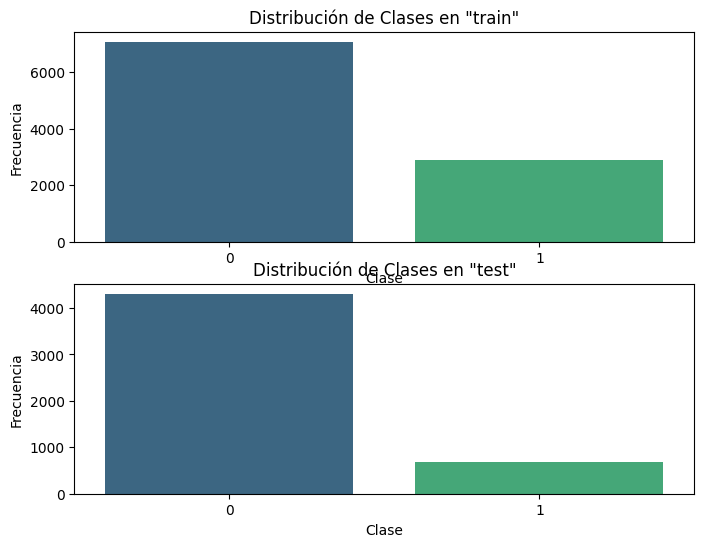

In [33]:
matplotlib.pyplot.figure(figsize=(8, 6))

matplotlib.pyplot.subplot(2, 1, 1)
seaborn.countplot(x='label', data=df_train_corrected, palette='viridis')
matplotlib.pyplot.title('Distribución de Clases en "train"')
matplotlib.pyplot.xlabel('Clase')
matplotlib.pyplot.ylabel('Frecuencia')

matplotlib.pyplot.subplot(2, 1, 2)
seaborn.countplot(x='label', data=df_test, palette='viridis')
matplotlib.pyplot.title('Distribución de Clases en "test"')
matplotlib.pyplot.xlabel('Clase')
matplotlib.pyplot.ylabel('Frecuencia')

matplotlib.pyplot.show()

Veamos rápidamente si hay alguna diferencia entre las dos clases con respecto al origen del texto.

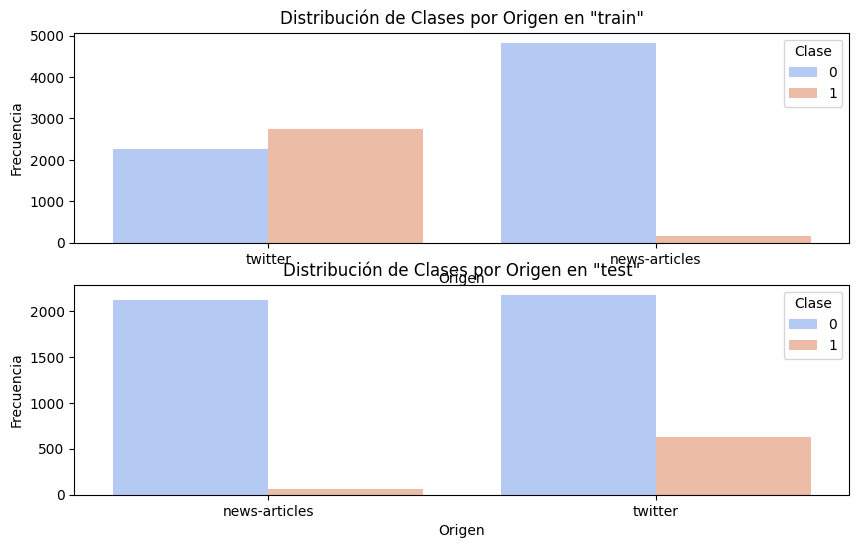

In [34]:
matplotlib.pyplot.figure(figsize=(10, 6))

matplotlib.pyplot.subplot(2, 1, 1)
seaborn.countplot(
    x='origin',
    hue='label',
    data=df_train_corrected, palette='coolwarm'
    )
matplotlib.pyplot.title('Distribución de Clases por Origen en "train"')
matplotlib.pyplot.xlabel('Origen')
matplotlib.pyplot.ylabel('Frecuencia')
matplotlib.pyplot.legend(title='Clase')

matplotlib.pyplot.subplot(2, 1, 2)
seaborn.countplot(
    x='origin',
    hue='label',
    data=df_test, palette='coolwarm'
    )
matplotlib.pyplot.title('Distribución de Clases por Origen en "test"')
matplotlib.pyplot.xlabel('Origen')
matplotlib.pyplot.ylabel('Frecuencia')
matplotlib.pyplot.legend(title='Clase')

matplotlib.pyplot.show()

Por lo que vemos en la última gráfica, tanto en el dataset de entrenamiento como en el de evaluación, la mayoría de los ejemplos de lenguaje tóxico provienen de Twitter, a pesar de que el origen de los textos sí está equilibrado en los datasets. Esto no tendrá ninguna repercusión en nuestro modelo.

**Oversampling & Undersampling:**

Una manera de solventar este desajuste en la distribución de clases sería la técnica de *oversampling/undersampling*. Esta técnica se basa en la generación de ejemplos sintéticos de la clase minoritaria y en la eliminación aleatoria de ejemplos de la clase mayoritaria, de forma que se iguale la proporción de clases.

Por un lado, no disponemos de una gran cantidad de datos, por lo que el *undersampling*, es decir, eliminar ejemplos del dataset para equilibrar las clases (lo que requeriría una gran cantidad de datos borrados) podría ser perjudicial para el desempeño del modelo.

Por otro lado, la generación de sintética de datos de la clase minoritaría (*oversampling*) puede llevar a la introducción de un sesgo, pues esta técnica implica replicar instancias de la clase minoritaria para aumentar su representación. Esta introducción de ejemplos redundantes puede llevar a una situación de *overfitting* del modelo.

Además, una de las restricciones que tenemos en esta prueba es no modificar el dataset "test", por lo que incluso si utilizáramos la técnica de *oversampling/undersampling* evitando sus riesgos, aún tendríamos un desajuste de clases enorme en el conjunto de datos de prueba.

**Ponderación de clases durante el entrenamiento:**

Otra manera de intentar evitar que este desajuste afecte al entrenamiento del modelo, es ponderar las clases en base a su ratio de desajuste. Esto ayudaría al modelo a prestar más atención a los ejemplos de la clase menos frecuente y a mitigar el impacto del desbalanceo.

Aunque esta ténica (como cualquier otra) no es una solución perfecta, es posiblemente la mejor opción para cumplir con los objetivos de la prueba, dadas sus restricciones.

### 1.3 Longitud de los textos:

Analizar la longitud de los textos en el contexto del fine-tuning de un modelo para la clasificación de los mismos puede ser útil por varias razones, por ejemplo:
- conocer la distribución de la longitud de los textos nos permitirá determinar una longitud máxima adecuada para el modelo
- podríamos decidir excluir textos extremadamente cortos o largos durante el preprocesamiento

En el contexto de esta prueba, entenderemos "longitud del texto" como número de tokens en el texto original.

In [35]:
# add length columns containing the number of tokens in the text
df_train_corrected['text_length_es'] = df_train_corrected['text'].apply(
    lambda x: len(x.split())
    )
df_train_corrected['text_length_en'] = df_train_corrected['english'].apply(
    lambda x: len(x.split())
    )
df_train_corrected['text_length_fr'] = df_train_corrected['french'].apply(
    lambda x: len(x.split())
    )

Comenzamos viendo las longitudes comparadas entre idiomas:

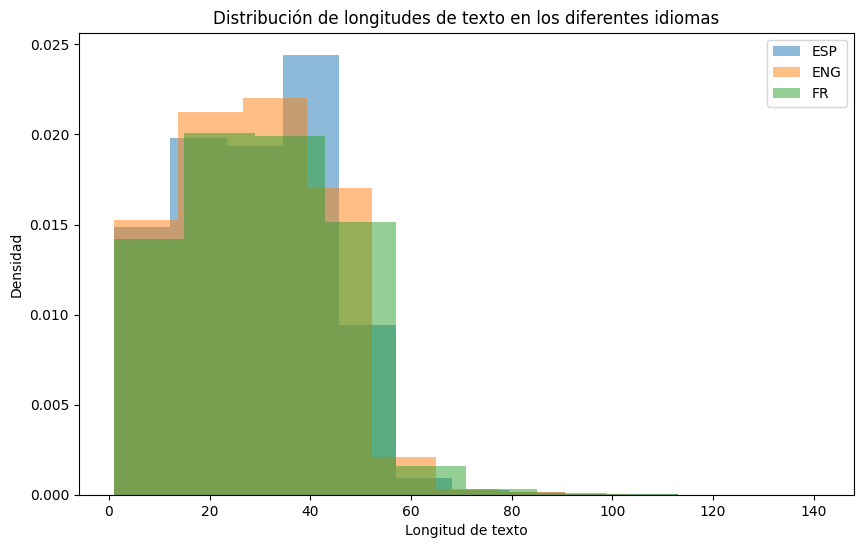

In [36]:
matplotlib.pyplot.figure(figsize=(10, 6))
matplotlib.pyplot.hist(
    df_train_corrected['text_length_es'],
    bins=10,
    alpha=0.5,
    label='ESP',
    density=True
    )
matplotlib.pyplot.hist(
    df_train_corrected['text_length_en'],
    bins=10, alpha=0.5,
    label='ENG',
    density=True
    )
matplotlib.pyplot.hist(
    df_train_corrected['text_length_fr'],
    bins=10,
    alpha=0.5,
    label='FR',
    density=True
    )

matplotlib.pyplot.title('Distribución de longitudes de texto en los diferentes idiomas')
matplotlib.pyplot.xlabel('Longitud de texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

Tenemos un histograma que compara las distribuciones de las longitudes de texto en español, inglés y francés. Cada barra representa un rango de longitudes, y la altura de la barra indica la frecuencia relativa de textos en ese rango de longitudes.

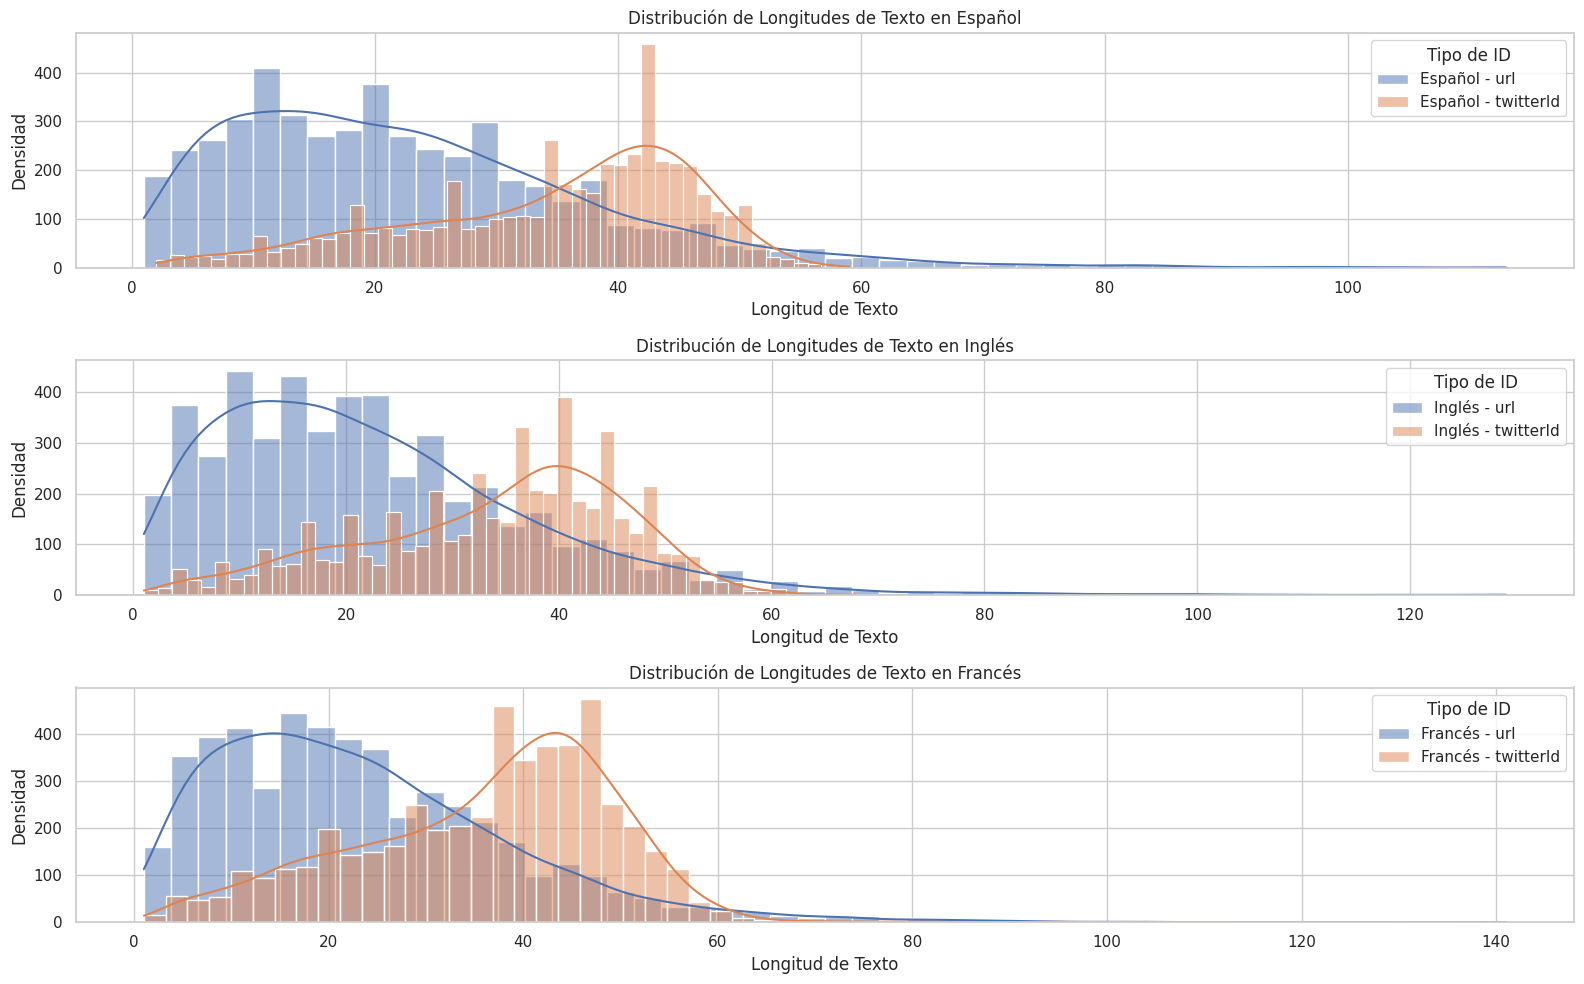

In [37]:
seaborn.set(style="whitegrid")

matplotlib.pyplot.figure(figsize=(16, 10))

matplotlib.pyplot.subplot(3, 1, 1)
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'url'], x='text_length_es', bins=50, alpha=0.5, kde=True, label='Español - url')
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'twitterId'], x='text_length_es', bins=50, alpha=0.5, kde=True, label='Español - twitterId')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Español')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Tipo de ID')

matplotlib.pyplot.subplot(3, 1, 2)
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'url'], x='text_length_en', bins=50, alpha=0.5, kde=True, label='Inglés - url')
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'twitterId'], x='text_length_en', bins=50, alpha=0.5, kde=True, label='Inglés - twitterId')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Inglés')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Tipo de ID')

matplotlib.pyplot.subplot(3, 1, 3)
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'url'], x='text_length_fr', bins=50, alpha=0.5, kde=True, label='Francés - url')
seaborn.histplot(data=df_train_corrected[df_train_corrected['id-type'] == 'twitterId'], x='text_length_fr', bins=50, alpha=0.5, kde=True, label='Francés - twitterId')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Francés')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Tipo de ID')

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

Por lo que podemos ver, los textos que provienen de Twitter tienden a tener una mayor longitud.

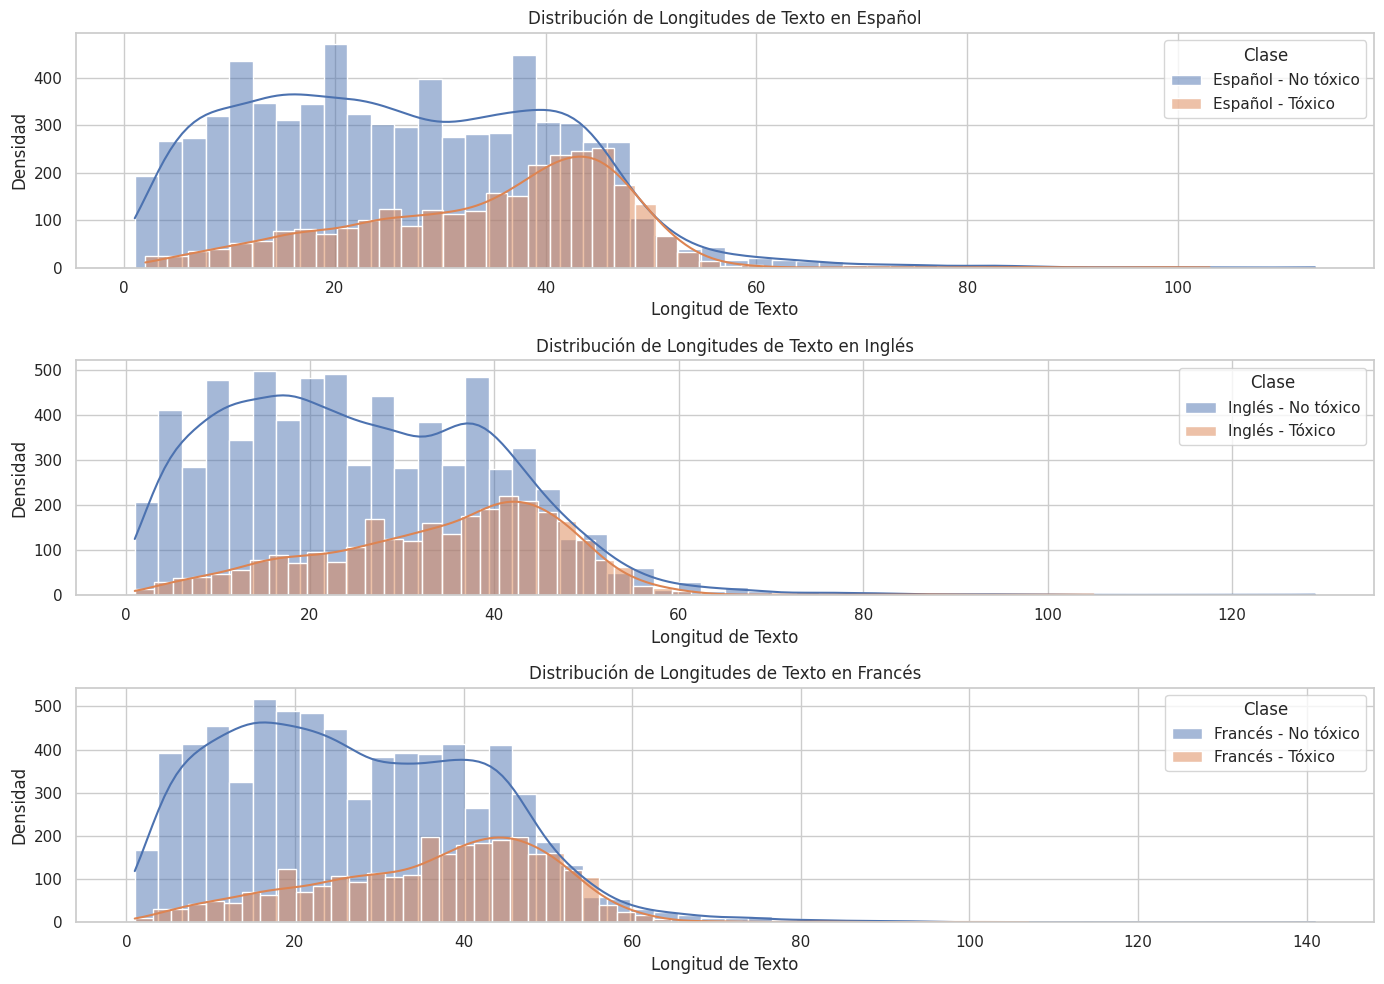

In [38]:
seaborn.set(style="whitegrid")

matplotlib.pyplot.figure(figsize=(14, 10))

matplotlib.pyplot.subplot(3, 1, 1)
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 0], x='text_length_es', bins=50, alpha=0.5, kde=True, label='Español - No tóxico')
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 1], x='text_length_es', bins=50, alpha=0.5, kde=True, label='Español - Tóxico')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Español')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Clase')

matplotlib.pyplot.subplot(3, 1, 2)
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 0], x='text_length_en', bins=50, alpha=0.5, kde=True, label='Inglés - No tóxico')
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 1], x='text_length_en', bins=50, alpha=0.5, kde=True, label='Inglés - Tóxico')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Inglés')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Clase')

matplotlib.pyplot.subplot(3, 1, 3)
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 0], x='text_length_fr', bins=50, alpha=0.5, kde=True, label='Francés - No tóxico')
seaborn.histplot(data=df_train_corrected[df_train_corrected['label'] == 1], x='text_length_fr', bins=50, alpha=0.5, kde=True, label='Francés - Tóxico')
matplotlib.pyplot.title('Distribución de Longitudes de Texto en Francés')
matplotlib.pyplot.xlabel('Longitud de Texto')
matplotlib.pyplot.ylabel('Densidad')
matplotlib.pyplot.legend(title='Clase')

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

También observamos que los textos de la clase "Tóxico" tienen una tendencia creciente en su longitud hasta alcanzar, aproximadamente, las 50 palabras, a partir de donde su longitud decrece de forma muy similar a los de la clase "No tóxico".

### 1.4 Palabras más comunes:

En esta subsección hacemos un pequeño análisis visual de las palabras más comunes por clase. En concreto, mostraremos las palabras más comunes en cada tipo de lenguaje que no estén entre las más comunes del otro tipo. De esta forma observaremos cuáles son las palabras que más influirán en el modelo a la hora de clasificar el texto. Mostramos estos resultados sólo para el caso del español.

In [39]:
# divide dataframe by classes
df_toxic = df_train_corrected[df_train_corrected['label'] == 1]
df_non_toxic = df_train_corrected[df_train_corrected['label'] == 0]

In [40]:
def get_top_words_no_common(
    text_1: pandas.Series,
    text_2: pandas.Series,
    top_n: int = 20
    ) -> tuple[pandas.Series, pandas.Series]:
    """
    Get most common words of the set differences of two texts.

    The function gets as input two pandas series from where the words are
    obtained. Then, the set differences of the words are computed, that is,
    common words between sets removed. Finally, the top n words of each set not
    present in the other are added to a pandas series, which are returned.

    Args:
        text_1 (pandas.Series): pandas series containing the 1st text
        text_1 (pandas.Series): pandas series containing the 2nd text
        top_n (int): number of words to include in the result

    Returns:
        top_words_df1 (pandas.Series): the resulting top n words in the 1st text
        top_words_df2 (pandas.Series): the resulting top n words in the 2nd text
    """

    words_df1 = ' '.join(text_1).split()
    words_df2 = ' '.join(text_2).split()

    # compute set differences of words from each text
    words_unique_df1 = set(words_df1) - set(words_df2)
    words_unique_df2 = set(words_df2) - set(words_df1)

    # get top_n most common words of each set and not included in the other set
    top_words_df1 = (
        pandas.Series(words_df1).value_counts().loc[
            lambda x: x.index.isin(words_unique_df1)
            ].head(top_n)
            )
    top_words_df2 = (
        pandas.Series(words_df2).value_counts().loc[
            lambda x: x.index.isin(words_unique_df2)
            ].head(top_n)
            )

    return top_words_df1, top_words_df2

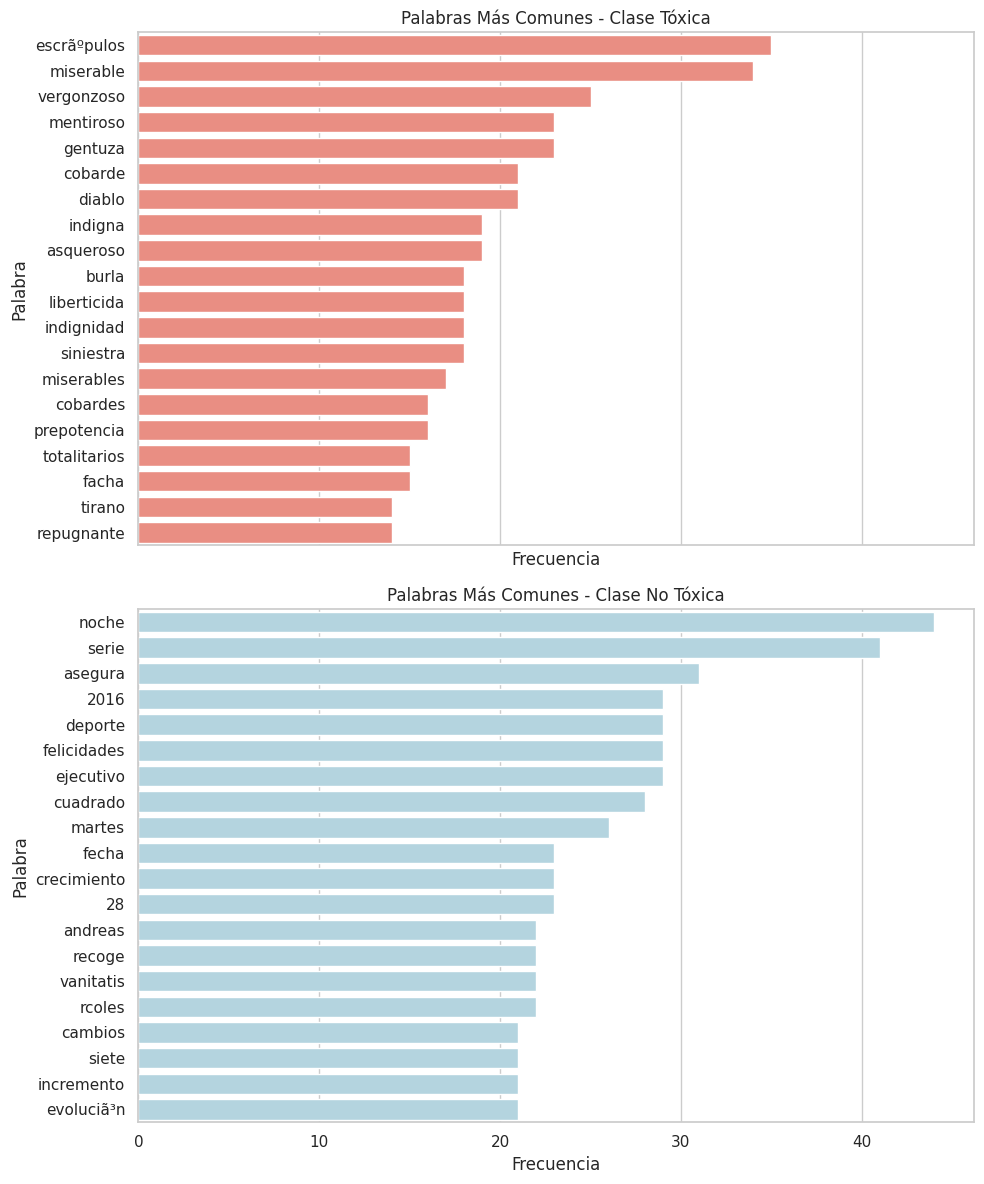

In [41]:
# get most common not shared words of each class (toxic/non toxic)
top_words_toxic, top_words_non_toxic = get_top_words_no_common(
    df_toxic['text_processed_es'],
    df_non_toxic['text_processed_es']
    )

fig, axes = matplotlib.pyplot.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 12),
    sharex=True
    )

seaborn.barplot(
    x=top_words_toxic.values,
    y=top_words_toxic.index,
    ax=axes[0],
    color='salmon'
    )
axes[0].set_title('Palabras Más Comunes - Clase Tóxica')
axes[0].set_xlabel('Frecuencia')
axes[0].set_ylabel('Palabra')

seaborn.barplot(
    x=top_words_non_toxic.values,
    y=top_words_non_toxic.index,
    ax=axes[1],
    color='lightblue'
    )
axes[1].set_title('Palabras Más Comunes - Clase No Tóxica')
axes[1].set_xlabel('Frecuencia')
axes[1].set_ylabel('Palabra')

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

Parece bastante razonable la división de palabras encontrada.

# 2. Fine-tuning de modelo pre-entrenado

### 2.1 Entrenamiento del modelo:

Una vez hemos comprendido la estructura de los datos y los hemos pre-procesado de acuerdo a las necesidades que hemos definido, procedemos a la elección de un modelo de lenguage pre-entrenado para su fine-tuning con nuestros datos.

Para esta tarea, hemos elegido el modelo XLM-RoBERTa en su versión base. Este modelo es una variante de BERT que ha sido pre-entrenada en grandes cantidades de datos multilingües, lo que le permite manejar texto en varios idiomas con buen rendimiento, por lo que debería de ser un buen candidato para nuestra tarea de clasificación.

A continuación, ponderamos los pesos de las clases tóxico/no tóxico para mitigar el desajuste de balance entre una y otra (esta fue la solución propuesta en el primer apartado cuando se observó este problema), dividimos los datos en entrenamiento y validación, y definimos el tokenizador del modelo.

In [42]:
# compute weights classes to balance during training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=[0, 1],
    y=numpy.array(df_train_corrected['label'])
    )
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [43]:
# divide data into train and validation
train, validation = train_test_split(
    df_train_corrected,
    test_size=0.2,
    random_state=42
    )

In [44]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

Ahora definimos una clase de tipo `Dataset` que nos permita cargar y acceder a los datos para entrenar un modelo de PyTorch.

In [45]:
class ToxicityDataset(Dataset):
    """Instance of a toxicity dataset."""

    def __init__(self, texts, labels, max_length=162):
        """Initialise the toxicity dataset."""
        self.texts = texts
        self.labels = labels
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        """Return length of dataset."""
        return len(self.labels)

    def __getitem__(self, idx):
        """Return data into model form."""
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx])

        # tokenize texts
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': label
        }

Los objetos de tipo `Dataset` son comúnmente utilizados junto con los `DataLoader` de PyTorch. Los `DataLoader` proporcionan una forma conveniente de cargar los datos en lotes y paralelizar la carga de datos, lo que puede mejorar significativamente la eficiencia durante el entrenamiento.

A continuación, escribimos una función donde preparamos los datos para su uso por el modelo. La función realiza las siguientes tareas:


*   crear un dataframe con los textos pre-procesados de los diferentes idiomas concatenados, junto con sus etiquetas asociadas.
*   codificar estos datos con el tokenizador del modelo.
*   utilizar la clase de tipo `Dataset` y un `DataLoader` para crear los datos de entramiento en el formato que requiere el modelo.

In [46]:
def create_data_loader(
    df: pandas.DataFrame,
    columns: list,
    shuffle=True
    ) -> DataLoader:
    """
    Uses the data to create a DataLoader for model consumption.

    Args:
      df (pandas.DataFrame): dataframe containing text and label data
      columns (list): list of dataframe columns names containing the text
      shuffle (bool): bool indicating whether or not to shuffle the DataLoader

    Return:
      DataLoader: data loader for model consumption
    """
    # concat Spanish, English and French texts
    concatenated_texts = (
        df[columns[0]].tolist() +
        df[columns[1]].tolist() +
        df[columns[2]].tolist()
    )

    # get the labels (equal for the 3 languages)
    labels = df['label'].tolist() * 3

    # create dataframe with concatenated text and labels
    concatenated_df = pandas.DataFrame(
        {'text': concatenated_texts, 'label': labels}
        )

    # encode data
    encoded_data = tokenizer(
        concatenated_df['text'].astype(str).values.tolist(),
        truncation=True,
        padding=True,
        return_tensors='pt'
    )

    # create dataset
    dataset = ToxicityDataset(encoded_data, labels)

    return DataLoader(dataset, batch_size=8, shuffle=shuffle)

En las tres siguientes celdas tenemos las funciones para el entrenamiento y la validación de una época de entrenamiento para nuestro modelo de clasificación, así como la función que utilizaremos para su evaluación.

La función `train_epoch` realiza el bucle de entrenamiento sobre los datos de entrenamiento, actualiza los parámetros del modelo para minimizar la pérdida y calcula las métricas de rendimiento, en este caso, la precisión y la pérdida promedio, para esa época específica.

Por su parte, la función `validate_epoch` realiza una evaluación del modelo sobre los datos de validación, calcula la precisión y la pérdida promedio y retorna estos valores para su análisis.

La función `evaluate_model` realiza una evaluación del modelo sobre los datos de testing y devuelve las predicciones hechas por el modelo así como los valores reales de las etiquetas.

In [47]:
def train_epoch(
    model: torch.nn.Module,
    criterion: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader,
    optimizer: torch.optim,
    device: str,
    n_examples: int
) -> tuple[torch.Tensor, numpy.float64]:
    """
    Runs one epoch of training for the model.

    Args:
      model (torch.nn.Module): model to be trained
      criterion (torch.nn.CrossEntropyLoss): loss function for class
      weights ponderation
      dataloader (DataLoader): dataloader for model consumption
      optimizer (torch.optim): model optimizer
      device (str): string indicating what device to be used
      n_examples (int): length of training dataset

    Return:
      tuple[torch.Tensor, numpy.float64]: train accuracy and loss of epoch
    """
    model.train()

    losses = []
    correct_predictions = 0

    # iterate over batches of the dataloader
    for batch in tqdm(dataloader, desc=f'Training'):
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['label'].to(device)
        }
        # compute the outputs of the model using the input data
        outputs = model(**inputs)

        # compute the loss comparing the outputs of the model and the labels
        # using the CrossEntropyLoss loss function
        loss = criterion(outputs.logits, inputs['labels'])
        losses.append(loss.cpu().item())

        # track the number of correct predictions
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(
            predictions == batch['label'].to(device)
            )

        # back-propagate, optimize model parameters and re-start gradients
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return (
        correct_predictions.cpu().double() / n_examples,
        sum(losses) / len(losses)
        )

In [48]:
def validate_epoch(
    model: torch.nn.Module,
    criterion: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader,
    device: str,
    n_examples: int
) -> tuple[torch.Tensor, numpy.float64]:
    """
    Runs one epoch of validation for the model.

    Args:
      model (torch.nn.Module): model for validation
      criterion (torch.nn.CrossEntropyLoss): loss function for class
      weights ponderation
      dataloader (DataLoader): dataloader for model consumption
      device (str): string indicating what device to be used
      n_examples (int): length of validation dataset

    Return:
      tuple[torch.Tensor, numpy.float64]: validation accuracy and loss of epoch
    """
    model.eval()

    losses = []
    correct_predictions = 0

    # avoid gradients computation during validation (not to update parameters)
    with torch.no_grad():
        # iterate over batches of the dataloader
        for batch in tqdm(dataloader, desc=f'Validación'):
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['label'].to(device)
            }
            # compute the outputs of the model using the input data
            outputs = model(**inputs)

            # compute the loss comparing the outputs of the model and the labels
            # using the CrossEntropyLoss loss function
            loss = criterion(outputs.logits, inputs['labels'])
            losses.append(loss.cpu().item())

            # track the number of correct predictions
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(
                predictions == batch['label'].to(device)
                )

    return (
        correct_predictions.cpu().double() / n_examples,
        sum(losses) / len(losses)
        )

In [49]:
def evaluate_model(
    model: torch.nn.Module,
    dataloader: DataLoader,
    device: str
) -> tuple[list, list]:
    """
    Evaluate the model on given data and return predictions and true labels.

    Args:
      model (torch.nn.Module): model for validation
      dataloader (DataLoader): dataloader for model consumption
      device (str): string indicating what device to be used

    Return:
      tuple[list, list]: list containing true labels and predictions
    """
    model.eval()
    y_true = []
    y_pred = []

    # avoid gradients computation during evaluation
    with torch.no_grad():
        # iterate over batches of the dataloader
        for batch in tqdm(dataloader, desc=f'Evaluación'):
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['label'].to(device)
            }
            # compute the outputs of the model using the input data
            outputs = model(**inputs)

            # store the predictions and the true labels
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            y_true.extend(batch['label'].tolist())
            y_pred.extend(predictions.tolist())

    return y_true, y_pred

Una vez definidas las clases y funciones necesarias para el formato de datos, el entrenamiento, la validación y la evaluación del modelo, comenzamos a invocar a cada una de ellas para iniciar el fine-tuning del modelo.

In [50]:
# create dataloaders for all data
train_dataloader = create_data_loader(
    train,
    ['text_processed_es', 'text_processed_en', 'text_processed_fr']
    )
validation_dataloader = create_data_loader(
    validation,
    ['text_processed_es', 'text_processed_en', 'text_processed_fr']
    )
test_dataloader = create_data_loader(
    df_test,
    ['text', 'english', 'french'],
    shuffle=False
    )

Para el entrenamiento se ha elegido un optimizador de tipo AdamW. Este optimizador es una variante del optimizador Adam que corrige un problema de sesgo en la actualización de pesos. La adición de términos de peso de decaimiento es beneficioso para el entrenamiento, ya que ayuda a prevenir un sobreajuste excesivo y mejora la generalización del modelo.

La tasa de aprendizaje (learning rate) es un hiperparámetro que determina el tamaño de los pasos que el optimizador toma durante el entrenamiento. Un valor de 5e-5 es un valor comúnmente utilizado y suele funcionar bien para modelos preentrenados como XLM-RoBERTa.

Por otro lado, se utiliza una función de pérdida `CrossEntropyLoss`, una de las más habituales en los problemas de clasificación binaria y multiclase.

In [51]:
model = AutoModelForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=2
    ).to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights.to(device),
    reduction='mean'
    )

num_epochs = 3
model_path = 'model/toxicity_model.bin'

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Comenzamos el entrenamiento del modelo utilizando las funciones `train_epoch` y `validate_epoch`.

In [52]:
# training loop
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []
best_accuracy = 0

for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")
  print("-" * 10)

  train_acc, train_loss = train_epoch(
      model,
      criterion,
      train_dataloader,
      optimizer,
      device,
      len(train)
      )
  val_acc, val_loss = validate_epoch(
      model,
      criterion,
      validation_dataloader,
      device,
      len(validation)
      )

  train_accuracies.append(train_acc)
  train_losses.append(train_loss)
  val_accuracies.append(val_acc)
  val_losses.append(val_loss)

  print(
      f'Training Accuracy: {train_acc:.4f}, Training Loss: {train_loss:.4f}'
      )
  print(
      f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}'
      )

  if val_acc > best_accuracy:
        torch.save(model.state_dict(), model_path)
        best_accuracy = val_acc

Epoch 1/3
----------


Validación: 100%|██████████| 750/750 [01:18<00:00,  9.53it/s]


Training Accuracy: 1.8225, Training Loss: 0.6973
Validation Accuracy: 2.1216, Validation Loss: 0.6912
Epoch 2/3
----------


Validación: 100%|██████████| 750/750 [01:10<00:00, 10.67it/s]


Training Accuracy: 1.8806, Training Loss: 0.6958
Validation Accuracy: 2.1216, Validation Loss: 0.6912
Epoch 3/3
----------


Validación: 100%|██████████| 750/750 [01:15<00:00,  9.88it/s]

Training Accuracy: 1.8965, Training Loss: 0.6951
Validation Accuracy: 2.1216, Validation Loss: 0.6918


Mostramos en una gráfica las métricas de precisión y pérdida recogidas durante el entrenamiento.

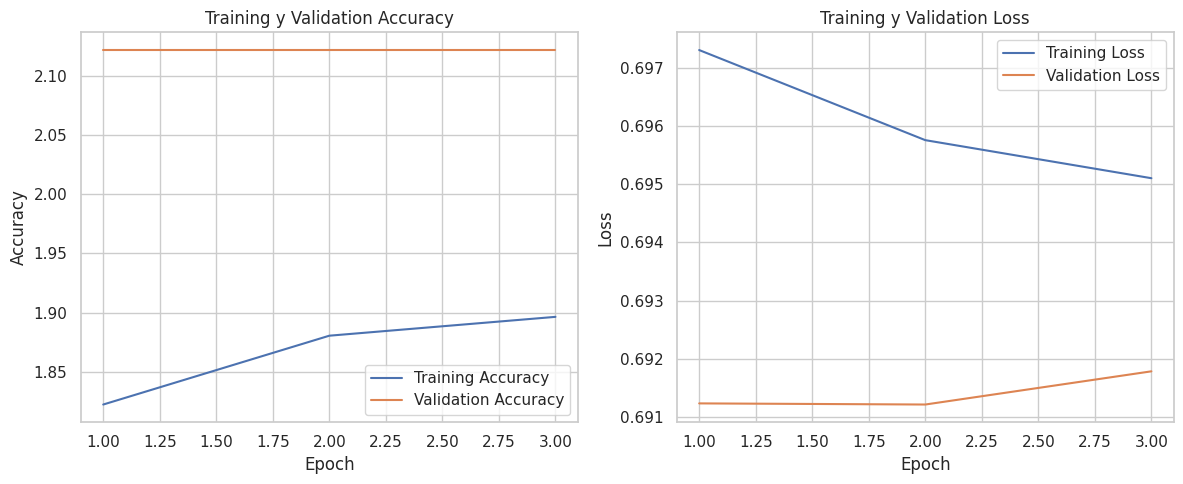

In [53]:
epochs = list(range(1, num_epochs + 1))

matplotlib.pyplot.figure(figsize=(12, 5))

matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.plot(epochs, train_accuracies, label='Training Accuracy')
matplotlib.pyplot.plot(epochs, val_accuracies, label='Validation Accuracy')
matplotlib.pyplot.title('Training y Validation Accuracy')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.legend()

matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.plot(epochs, train_losses, label='Training Loss')
matplotlib.pyplot.plot(epochs, val_losses, label='Validation Loss')
matplotlib.pyplot.title('Training y Validation Loss')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Loss')
matplotlib.pyplot.legend()

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

### 2.2 Evaluación del modelo entrenado:

Por último, evaluamos el modelo sobre los datos de evaluación y sacamos las conclusiones necesarias.

In [54]:
# get true labels and predictions from test data
true_labels, predictions = evaluate_model(model, test_dataloader, device)

Evaluación: 100%|██████████| 1875/1875 [03:26<00:00,  9.07it/s]


Hemos elegido las métricas más habituales para evaluar modelos de clasificación como este: accuracy, precision, recall, f1-score y support. Se muestra además la matriz de confusión.


*   accuracy: mide la proporción de predicciones correctas sobre el total de predicciones
*   precision: TP/(TP + FP), es decir, mide la calidad de las predicciones positivas
*   recall: TP/(TP + FN), es decir, mide la capacidad del modelo para capturar todas las instancias positivas
*   f1-score: combina precision y recall en una sola métrica (media armónica), útil cuando hay un desbalance entre las clases
*   soporte: número total de instancias en una clase
*   matriz de confusión: muestra el número de predicciones correctas e incorrectas clasificadas en cada clase



In [55]:
# evaluate model with metrics
print("\nTest Accuracy:", accuracy_score(true_labels, predictions))
print("\nClassification Report:")
print(classification_report(true_labels, predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))


Test Accuracy: 0.8616

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93     12924
           1       0.00      0.00      0.00      2076

    accuracy                           0.86     15000
   macro avg       0.43      0.50      0.46     15000
weighted avg       0.74      0.86      0.80     15000


Confusion Matrix:
[[12924     0]
 [ 2076     0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Por último, representamos la curva "Receiver Operating Characteristic" (ROC) y calculamos su área por debajo de la curva (AUC).

La curva ROC es útil para visualizar cómo varía el rendimiento del clasificador. Un AUC más alto indica un mejor rendimiento del modelo en términos de discriminación entre clases. La línea punteada representa el rendimiento de un clasificador aleatorio, y el objetivo es que la curva ROC del modelo esté por encima de esta línea.

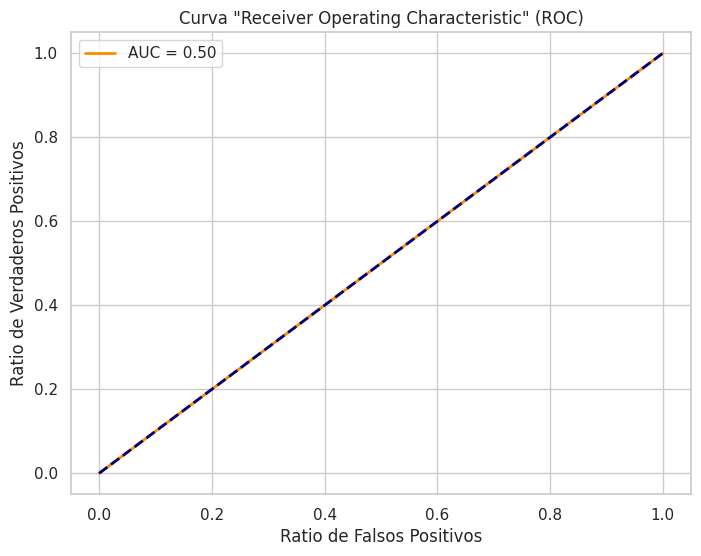

In [56]:
# compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# plot ROC curve and AUC value
matplotlib.pyplot.figure(figsize=(8, 6))
matplotlib.pyplot.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
matplotlib.pyplot.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
matplotlib.pyplot.xlabel('Ratio de Falsos Positivos')
matplotlib.pyplot.ylabel('Ratio de Verdaderos Positivos')
matplotlib.pyplot.title('Curva "Receiver Operating Characteristic" (ROC)')
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

Esta representación indica que nuestro modelo hace predicciones aleatorias.

Sacamos las siguientes conclusiones de los resultados de la evaluación del modelo:

1. **Desbalance de clases:** La clase 1 tiene un bajo support, y la precision, recall y f1-score para la clase 1 son todos 0. Esto indica un desbalance significativo entre las clases, donde el modelo no es capaz de predecir la clase minoritaria.

2. **AUC constante en 0.5:** El AUC constante en 0.5 en la curva ROC indica que el modelo no tiene capacidad para distinguir entre las clases.

3. **La accuracy elevada es engañosa:** A pesar de tener una alta precisión en el conjunto de prueba, esta métrica podría ser engañosa debido al desbalance de clases. El modelo parece inclinarse hacia predecir la clase mayoritaria, obteniendo una precisión alta simplemente prediciendo la clase 0 en la mayoría de los casos.

Sugerencias para mejorar el modelo:

- **Manejar el desbalance de clases:** Explorar otras técnicas de manejo de desbalance de clases, como la generación de datos sintéticos o el uso de algoritmos diseñados para manejar desbalances.

- **Ajuste de hiperparámetros:** Experimentar con los diferentes hiperparámetros del modelo.

### 2.3 Valoración del uso de un LLM para esta tarea:

Para la tarea planteada, incluso teniendo acceso a un LLM, probablemente no tiene sentido utilizarlo salvo algunos concretos.

En principio, con más tiempo para un tratamiento más intensivo de los datos y una mejor exploración de los hiperparámetros del modelo (así como otras experimentaciones que se podrían llevar a cabo), deberíamos ser capaces de conseguir un clasificador robusto con un ajuste de modelo como el planteado en la tarea.

Sin embargo, habría ciertos casos (que no se ajustan a los planteados en esta tarea) donde el uso de un LLM podría tener más sentido:


*   Si no se dispone de datos etiquetados (o la cantidad es muy pequeña), se podría aprovechar el "conocimiento general" del LLM siempre que las clases estén bien definidas y sean comprensibles para el LLM.
*   Si las clases fueses a cambiar habitualmente a lo largo del tiempo.
*   Si necesitásemos una salida algo más elaborada que simplemente la predicción de una clase.

En resumen, no debería de ser necesario el uso de un LLM para conseguir un buen clasificador como el que se ha planteado en la tarea.